### Faces recognition example using eigenfaces and SVM

In [1]:
# Load the some data (from lfw, labeled faces in the wild) to disk
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [3]:
import numpy as np
np.random.seed(42)

# Introspect the images array
n_samples, h, w = lfw_people.images.shape

# We ignore positional data at the moment
X = lfw_people.data
n_features = X.shape[1]

In [60]:
# Extract the label to predict - the names of the persons
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [61]:
print("Total dataset size:")
print ("n_samples: %d" % n_samples)
print ("n_features: %d" % n_features)
print ("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [62]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [63]:
from time import time
from sklearn.decomposition import PCA

# Compute a PCA (eigenfaces) on the face dataset
# (unsupervised feature extraction / dimensionality reduction)

n_components = 150
print ("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))


def measure_time_for(action):
    t_start = time()
    print ("Starting action...")
    result = action()
    print ("Done in %0.3fs" % (time() - t_start))
    return result
    
pca = measure_time_for(
        lambda : PCA(n_components=n_components, whiten=True, svd_solver='randomized').fit(X_train)
)

Extracting the top 150 eigenfaces from 966 faces
Starting action...
Done in 0.310s


In [64]:
print ("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = measure_time_for(lambda: 
                               pca.transform(X_train))
X_test_pca = measure_time_for(lambda: 
                               pca.transform(X_test))

Projecting the input data on the eigenfaces orthonormal basis
Starting action...
Done in 0.028s
Starting action...
Done in 0.010s


In [65]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC

# Train svm classification model on reduced dataset
param_grid = {
         'C': [1e3, 5e3, 1e4, 5e4, 1e5],
          'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
          }

t0 = time()

# Do grid search and fit classifier
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)

print("Done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search: %s" % clf.best_estimator_)

Done in 20.761s
Best estimator found by grid search: SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [66]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Do some quantitative evaluation of the model quality with the test set

print("Predicting the people names on the testing set")

y_pred = measure_time_for(lambda: 
                          clf.predict(X_test_pca)
                         )

print(classification_report(y_test, y_pred))

Predicting the people names on the testing set
Starting action...
Done in 0.075s
             precision    recall  f1-score   support

          0       0.86      0.46      0.60        13
          1       0.81      0.87      0.84        60
          2       0.95      0.67      0.78        27
          3       0.83      0.98      0.90       146
          4       0.95      0.80      0.87        25
          5       0.89      0.53      0.67        15
          6       1.00      0.81      0.89        36

avg / total       0.87      0.86      0.85       322



In [107]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=4, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        if len(titles[i]) == 2:
            pl.title(titles[i][0], size=12, color= "g" if titles[i][1] == True else "r")
        else:
            pl.title(titles[i], size=12)               
        pl.xticks(())
        pl.yticks(())

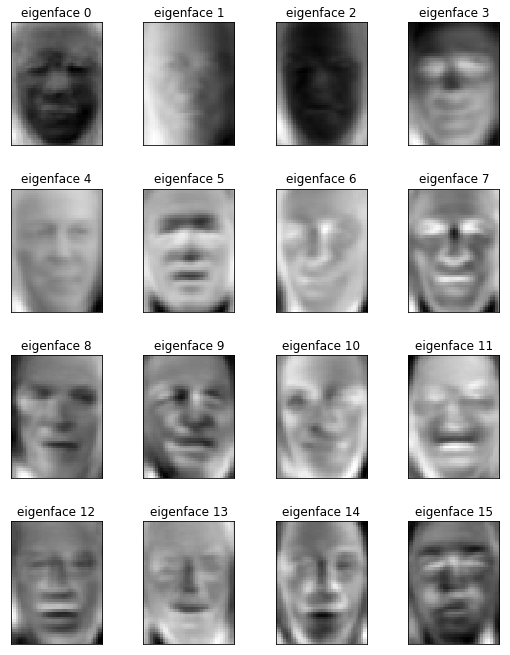

In [99]:
import matplotlib.pyplot as pl

# Extract most significant eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

# Plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

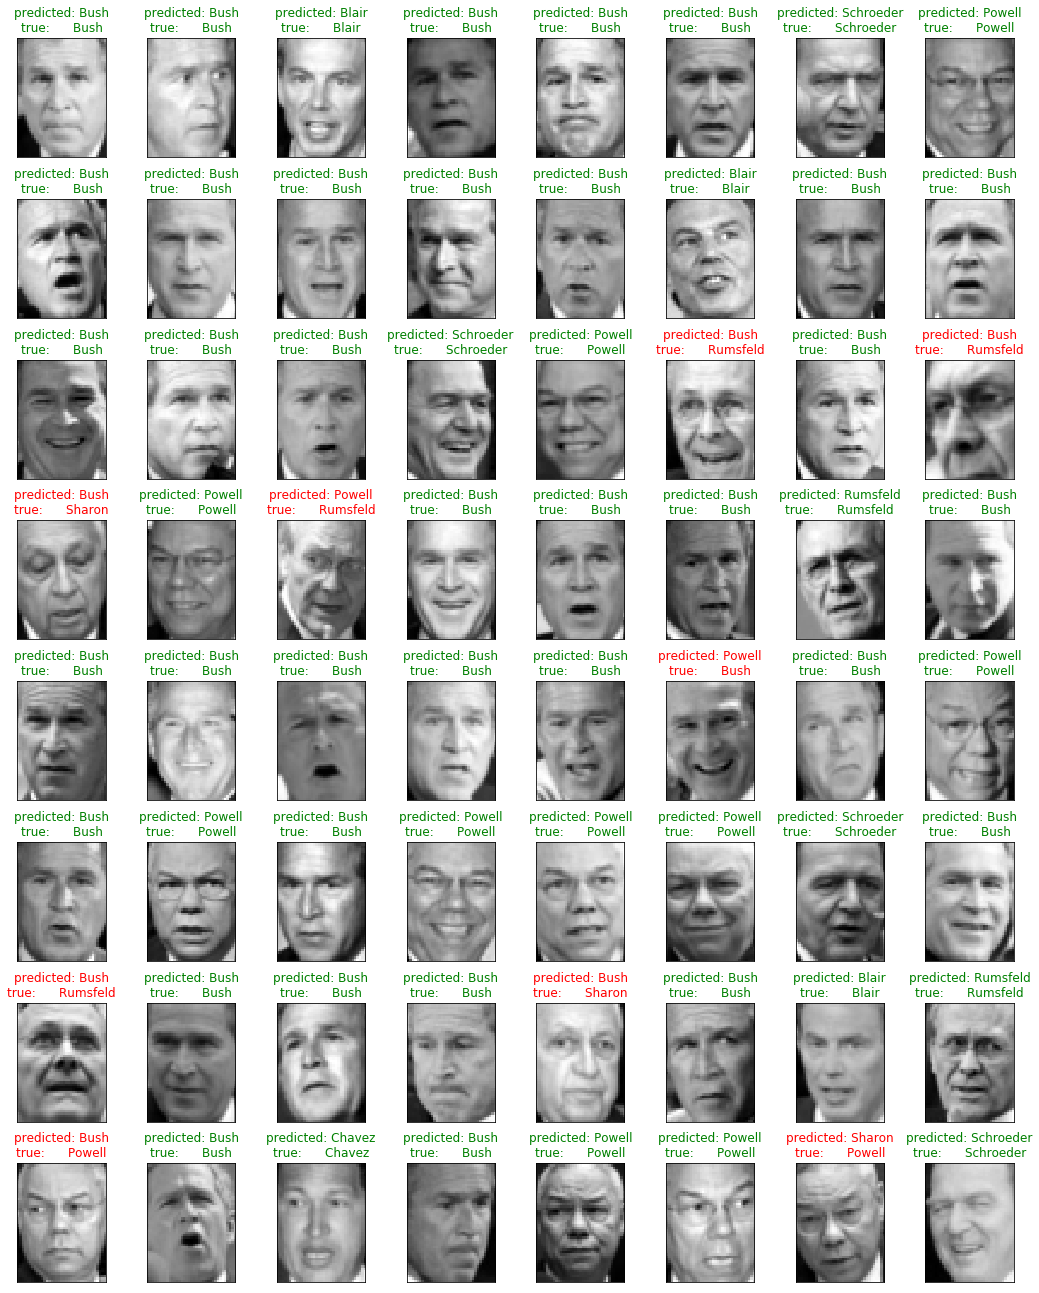

In [108]:
# Plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name), pred_name == true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w, 8, 8)

pl.show()